1. Declare constants

In [0]:
import copy
import os
import time
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

STORAGE_DIR = '/content/drive/My Drive/MyCNN'
STORAGE_MODEL = os.path.join(STORAGE_DIR, 'best-model')
DATA_DIR = '/content/knifey-data'
BATCH_SIZE = 32

2. Retrieve data from knifey-spoony dataset

In [2]:
def move_files(path: str, probabilities: dict, base_dir: str) -> None:
    base_in = os.path.join(base_dir, path)
    for file_name in os.listdir(base_in):
        if file_name == 'test':
            target = os.path.join(base_dir, 'test', path)
            print(target)
            shutil.rmtree(target, ignore_errors=True)
            shutil.move(os.path.join(base_in, file_name),
                        target)
            continue
        rand = random.random()
        total_prob = 0
        for prob, target in probabilities.items():
            target_dir = os.path.join(base_dir, target, path)
            total_prob += prob
            if rand < total_prob:
                shutil.move(os.path.join(base_dir, path, file_name),
                            os.path.join(base_dir, target_dir, file_name))
                break

def partition_image_data(path: str) -> int:
    target_probabilities = {
            0.8: 'train',
            0.2: 'validation',
    }
    dirs = [f.name for f in os.scandir(path) if f.is_dir()]
    print(dirs)

    for directory in dirs:
        for data_type in target_probabilities.values():
          sub = os.path.join(path, data_type, directory)
          shutil.rmtree(sub, ignore_errors=True)
          os.makedirs(sub)

    for directory in dirs:
      move_files(directory, target_probabilities, path)
    
    [shutil.rmtree(os.path.join(path, directory)) for directory in dirs]
    
    return len(dirs)

!rm -rf knifey-spoony
!git clone https://github.com/BeeblebroxIV/knifey-spoony.git
shutil.rmtree(DATA_DIR, ignore_errors=True)
os.mkdir(DATA_DIR)
!tar -xzf knifey-spoony/knifey-spoony.tar.gz --directory "/content/knifey-data"
NUM_CLASSES = partition_image_data(DATA_DIR)

Cloning into 'knifey-spoony'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 18 (delta 0), reused 2 (delta 0), pack-reused 15
Unpacking objects: 100% (18/18), done.
['forky', 'spoony', 'ladle', 'knifey']
/content/knifey-data/test/forky
/content/knifey-data/test/spoony
/content/knifey-data/test/knifey


3. Setup dataloaders as well as functions for training / visualisation

In [3]:
# TODO: precompute for dataset?
mean = [0.4399, 0.4211, 0.3609]
std = [0.1220, 0.1210, 0.1228]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          transform)
                  for x, transform in data_transforms.items()}
dataloaders = {x: torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=8)
              for x, dataset in image_datasets.items()}
dataset_sizes = {x: len(dataset) for x, dataset in image_datasets.items()}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make sure that we can store the model
os.makedirs(STORAGE_DIR, exist_ok=True)
print(STORAGE_DIR)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Storing')
                torch.save(model, STORAGE_MODEL)
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def test_model(model):
    running_loss = 0.0
    running_corrects = 0

            # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
    print('Loss:     {}'.format(epoch_loss))
    print('Accuracy: {}'.format(epoch_acc))


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/content/drive/My Drive/MyCNN


4. Train un-trained Classifier section of VGG16 with pre-trained features from imagenet

Using GPU:  True
Epoch 0/3
----------
train Loss: 1.1254 Acc: 0.5082
validation Loss: 0.6263 Acc: 0.7746
Storing

Epoch 1/3
----------
train Loss: 0.6956 Acc: 0.7097
validation Loss: 0.3521 Acc: 0.9065
Storing

Epoch 2/3
----------
train Loss: 0.5224 Acc: 0.7896
validation Loss: 0.2602 Acc: 0.9154
Storing

Epoch 3/3
----------
train Loss: 0.4572 Acc: 0.8184
validation Loss: 0.2289 Acc: 0.9213
Storing

Training complete in 3m 31s
Best val Acc: 0.921260


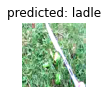

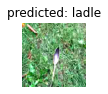

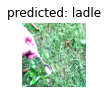

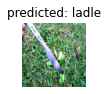

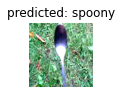

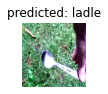

In [6]:
print("Using GPU: ", torch.cuda.is_available())

model_conv = torchvision.models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Replace last layer of classifier with untrained layer
# This is the "default" classifier, initialised without training
num_features = model_conv.classifier[6].in_features
features = list(model_conv.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, NUM_CLASSES)])
model_conv.classifier = nn.Sequential(*features)
model_conv.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2096, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, NUM_CLASSES),
)

model_conv = model_conv.to(device)


criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=12)

visualize_model(model_conv)

4. Load already trained model and continue training on last 10 layers

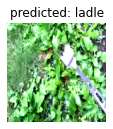

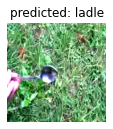

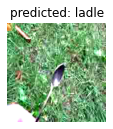

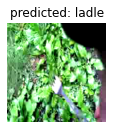

Unfreezing 10 out of 32 layers
Epoch 0/9
----------
train Loss: 0.5542 Acc: 0.7700
validation Loss: 0.2329 Acc: 0.9400
Storing

Epoch 1/9
----------
train Loss: 0.5061 Acc: 0.7988


KeyboardInterrupt: ignored

In [5]:
model_conv = torch.load(STORAGE_MODEL)
model_conv = model_conv.to(device)
visualize_model(model_conv, 4)
criterion = nn.CrossEntropyLoss()

params = list(model_conv.parameters())
unfreeze_nr = len(params) // 3
print("Unfreezing {} out of {} layers".format(unfreeze_nr, len(params)))
for param in params:
  param.requires_grad = False
for param in params[-10:]:
  param.requires_grad = True

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)


4. Export Model to onnx format for integration in OpenCV

In [4]:
model = torch.load(STORAGE_MODEL)
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')
#test_model(model)
torch.onnx.export(model, dummy_input,
                  os.path.join(STORAGE_DIR, "kitchen_classifier.onnx"),
                  opset_version=11)
print('Finished')

Finished
